In [3]:
!pip install --quiet neural-structured-learning
import matplotlib.pyplot as plt
import neural_structured_learning as nsl
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


## create TFrecord

In [4]:
DB_PATH = "/data/isabelle/wzs_p1_dip/metadata/p1-dip-metadata_1130.db"
output_tfrecord = "/data/isabelle/wzs_p1_dip/tfrecord"
TABEL_DEGREE_TXT = "/data/isabelle/wzs_p1_dip/table_degree.txt"
TABEL_LABEL_TXT = "/data/isabelle/wzs_p1_dip/table_label.txt"

In [5]:
N_DEGREE = 4
N_LABEL = 2

table_degree = tf.lookup.StaticHashTable(tf.lookup.TextFileInitializer(
    TABEL_DEGREE_TXT,
    tf.string, tf.lookup.TextFileIndex.WHOLE_LINE,
    tf.int64, tf.lookup.TextFileIndex.LINE_NUMBER
), N_DEGREE)
table_label = tf.lookup.StaticHashTable(tf.lookup.TextFileInitializer(
    TABEL_LABEL_TXT,
    tf.string, tf.lookup.TextFileIndex.WHOLE_LINE,
    tf.int64, tf.lookup.TextFileIndex.LINE_NUMBER
), N_LABEL)

In [6]:
def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=value))

def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=value))

def _float_feature(value):
    return tf.train.Feature(float_list=tf.train.FloatList(value=value))

def parse_fn(path, label, degree):
    img_byte_str = tf.io.read_file(path)
    label = table_label.lookup(label)
    degree = table_degree.lookup(degree)
    return img_byte_str, label, degree

def create_example(img_byte_str, label, degree):
    features = {
        "image": _bytes_feature(img_byte_str),
        "degree": _int64_feature(degree),
        "label": _int64_feature(label),
    }
    return tf.train.Example(features=tf.train.Features(feature=features))

In [7]:
##tf.data.experimental.SqlDataset(driver_name, data_source_name, query, output_types)

labels = [
    'NG',
    'OK',
]

for label in labels:
    dataset = tf.data.experimental.SqlDataset(
        "sqlite", DB_PATH,
        f"""select path, label, degree from metadata
        where
            label = '{label}' and
            degree >= 0 and
            component_class = 'label'
        """, (tf.string, tf.string, tf.string))
# Once you have a Dataset object, you can transform it into a new Dataset by 
# chaining method calls on the tf.data.Dataset object. 
# For example, you can apply per-element transformations such as Dataset.map(), 
# and multi-element transformations such as Dataset.batch().#
# map(map_func, num_parallel_calls=None, deterministic=None)
    
    dataset = dataset.map(parse_fn, tf.data.experimental.AUTOTUNE)

    tfrecord_path = f"{output_tfrecord}/{label}.tfrecord"
    with tf.io.TFRecordWriter(tfrecord_path) as writer:
        for img_byte_str, label, degree in dataset:
            example = create_example([img_byte_str.numpy()], [label.numpy()], [degree.numpy()])
            writer.write(example.SerializeToString())

Hyperparameters

In [8]:
class HParam():
    def __init__(self):
        self.channels = 3
        self.image_size = 32
        self.input_shape = (self.image_size, self.image_size, self.channels)
        
        self.shuffle_buffer = 10000
        self.batch_size = 1024
        self.valid_size = 3000
        
        self.epochs = 10
        self.steps_per_epoch = 100
        
        self.adv_multiplier = 2e-1
        self.adv_step_size = 2e-1

hparam = HParam()

## tutorials/adversarial_keras_cnn_HParams

In [9]:
class HParams(object):
      def __init__(self):
        self.channels = 3
        self.image_size = 32
        self.input_shape = [32, 32, 3]
        self.num_classes = 2
        self.conv_filters = [64, 128, 256]
        self.kernel_size = 3
        self.pool_size = (2, 2)
        self.num_fc_units = [64]
        self.shuffle_buffer = 1000
        self.batch_size = 500
        self.epochs = 100
        self.steps_per_epoch = 100
        self.valid_size = 4000
        self.adv_multiplier = 0.2
        self.adv_step_size = 0.2
        self.adv_grad_norm = 'infinity'

HPARAMS = HParams()

In [10]:
def build_base_model(hparams):
  #"""Builds a model according to the architecture defined in `hparams`."""
    inputs = tf.keras.Input(
          shape=hparams.input_shape)
    x = inputs
    for i, num_filters in enumerate(hparams.conv_filters):
        x = tf.keras.layers.Conv2D(
            num_filters, hparams.kernel_size, padding="same", activation='relu')(
                x)
        if i < len(hparams.conv_filters) - 1:
          # max pooling between convolutional layers
          x = tf.keras.layers.MaxPooling2D(hparams.pool_size)(x)
    x = tf.keras.layers.Flatten()(x)
    for num_units in hparams.num_fc_units:
        x = tf.keras.layers.Dense(num_units, activation='relu')(x)
    pred = tf.keras.layers.Dense(hparams.num_classes, activation='softmax')(x)
    model = tf.keras.Model(inputs=inputs, outputs=pred)
    return model

In [11]:
build_base_model(HPARAMS).summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 64)        1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 256)         295168    
_________________________________________________________________
flatten (Flatten)            (None, 16384)            

In [12]:
def parse_image(image):
    image = tf.io.decode_jpeg(image, HPARAMS.channels)
    image = tf.image.resize_with_pad(image, HPARAMS.image_size, HPARAMS.image_size)
    return image

def parse_single_example(example_proto):
    feature_spec = {
        "image": tf.io.FixedLenFeature([], tf.string),
        ##"degree": tf.io.FixedLenFeature([], tf.int64),
        "label": tf.io.FixedLenFeature([], tf.int64),
    }
    features = tf.io.parse_single_example(example_proto, feature_spec)

    features["image"] = parse_image(features["image"])
    ##features["degree"] = tf.one_hot(features["degree"], N_DEGREE)
    features["label"] = tf.one_hot(features["label"], N_LABEL)

    label = features["label"]
    return features, label

def convert_for_adv(features, label):
    return {
        "label": tf.cast(label, tf.float32),
        ##"degree": tf.cast(features["degree"], tf.float32),
        "image": features["image"],
    }

tfrecord_paths = [
    "/data/isabelle/wzs_p1_dip/tfrecord/NG.tfrecord",
    "/data/isabelle/wzs_p1_dip/tfrecord/OK.tfrecord"
]
datasets = [tf.data.TFRecordDataset(x).repeat() for x in tfrecord_paths]
dataset = tf.data.experimental.sample_from_datasets(datasets)
##You use the methods on SqlDataset to manipulate the data. For example, create a train/test split with:
train_ds = dataset.skip(HPARAMS.valid_size).shuffle(HPARAMS.shuffle_buffer).map(parse_single_example, tf.data.experimental.AUTOTUNE).batch(HPARAMS.batch_size).prefetch(tf.data.experimental.AUTOTUNE)
valid_ds = dataset.take(HPARAMS.valid_size).shuffle(HPARAMS.shuffle_buffer).map(parse_single_example, tf.data.experimental.AUTOTUNE).batch(HPARAMS.batch_size).prefetch(tf.data.experimental.AUTOTUNE)

In [50]:
valid_ds


<PrefetchDataset shapes: ({image: (None, 32, 32, 3), label: (None, 2)}, (None, 2)), types: ({image: tf.float32, label: tf.float32}, tf.float32)>

In [51]:
logdir = "/data/isabelle/wzs_p1_dip/base_model_isa"

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
callback_TB = tf.keras.callbacks.TensorBoard(logdir, write_graph=False, profile_batch=0)
base_model = build_base_model(HPARAMS)
base_model.compile("adam", "categorical_crossentropy", metrics=[tf.keras.metrics.CategoricalAccuracy()])

base_model.fit(train_ds, validation_data=valid_ds,
          epochs=HPARAMS.epochs,steps_per_epoch=HPARAMS.steps_per_epoch,
          callbacks=[callback, callback_TB], verbose=1)

Epoch 1/100


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/functional.py:543: UserWarning: Input dict contained keys ['image', 'label'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


100/100 [==============================] - 11s 113ms/step - loss: 4.8729 - categorical_accuracy: 0.9056 - val_loss: 0.3017 - val_categorical_accuracy: 0.8655
Epoch 2/100
100/100 [==============================] - 10s 104ms/step - loss: 0.0463 - categorical_accuracy: 0.9864 - val_loss: 1.4834 - val_categorical_accuracy: 0.6090
Epoch 3/100
100/100 [==============================] - 11s 108ms/step - loss: 0.0162 - categorical_accuracy: 0.9946 - val_loss: 1.4769 - val_categorical_accuracy: 0.7207
Epoch 4/100
100/100 [==============================] - 10s 103ms/step - loss: 0.0126 - categorical_accuracy: 0.9961 - val_loss: 0.0464 - val_categorical_accuracy: 0.9868
Epoch 5/100
100/100 [==============================] - 10s 103ms/step - loss: 0.0065 - categorical_accuracy: 0.9986 - val_loss: 0.0098 - val_categorical_accuracy: 0.9975
Epoch 6/100
100/100 [==============================] - 10s 100ms/step - loss: 0.0026 - categorical_accuracy: 0.9996 - val_loss: 0.0025 - val_categorical_accuracy:

KeyboardInterrupt: 

## Create a Confusion Matrix

In [129]:
results = base_model.evaluate(valid_ds)
named_results = dict(zip(base_model.metrics_names, results))
print('\naccuracy:', named_results)

8/8 [==============================] - 1s 100ms/step - loss: 4.4581e-06 - categorical_accuracy: 1.0000

accuracy: {'loss': 4.458062448975397e-06, 'categorical_accuracy': 1.0}


In [130]:
y_pred = base_model.predict(valid_ds)
print(y_pred)
print(type(y_pred))

[[1.0000000e+00 5.7198203e-17]
 [1.2896402e-09 1.0000000e+00]
 [1.0000000e+00 1.9448763e-13]
 ...
 [6.2181277e-15 1.0000000e+00]
 [1.0000000e+00 4.3265480e-10]
 [5.4323043e-12 1.0000000e+00]]
<class 'numpy.ndarray'>


In [108]:
len(y_true)

500

In [58]:
image_batch, label_batch = valid_ds.as_numpy_iterator().next()


In [105]:
y_true = []
y_pred = []
count = 0
prediction = base_model.predict(valid_ds)
batch = label_batch.shape[0]
for i in range(batch):
    count += 1
    if np.argmax(label_batch[i]) == 0:
        y_true.append('NG')
    else:
        y_true.append('OK')
    if np.argmax(prediction[i]) == 0:
        y_pred.append('NG')
    else:
        y_pred.append('OK')

In [106]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    for i in range(2):
        for j in range(2):
            c = cm[j,i]
            ax.text(i, j, str(c), va='center', ha='center')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

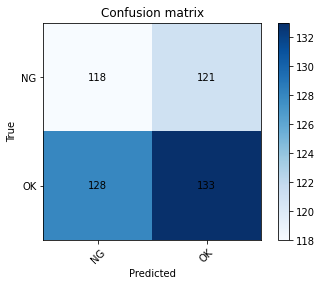

In [107]:
cnf_matrix = confusion_matrix(y_true, y_pred, labels=["NG", "OK"])

plot_confusion_matrix(cnf_matrix, classes=["NG", "OK"])

## Try on TF.math.confusion matrix(Fail)

In [ ]:
y_true = []
y_pred = []
count = 0
prediction = base_model.predict(valid_ds)

for i in range(5):
    count += 1
    if np.argmax(label_batch[i]) == 0:
        y_true.append('NG')
    else:
        y_true.append('OK')
    if np.argmax(prediction[i]) == 0:
        y_pred.append('NG')
    else:
        y_pred.append('OK')
    print("y_true:", label_batch[i],"y_pred:", prediction[i])
print("y_true:", y_true, "y_pred:", y_pred)

In [133]:
con_mat = tf.math.confusion_matrix(labels=y_true, predictions=y_pred)

InvalidArgumentError: Shapes of all inputs must match: values[0].shape = [500,2] != values[1].shape = [4000,2] [Op:Pack] name: stack

In [95]:
con_mat

array([[1, 0],
       [1, 0]], dtype=int32)

## Code from Robert

In [17]:
class HParam():
    def __init__(self):
        self.channels = 3
        self.image_size = 32
        self.input_shape = (self.image_size, self.image_size, self.channels)
        
        self.shuffle_buffer = 10000
        self.batch_size = 1024
        self.valid_size = 3000
        
        self.epochs = 100
        self.steps_per_epoch = 100
        
        self.adv_multiplier = 2e-1
        self.adv_step_size = 2e-1

hparam = HParam()

In [18]:
import tensorflow.keras.layers as l

def BaseModel():
    inputs = {
        "image": tf.keras.Input(hparam.input_shape, name="image"),
        "degree": tf.keras.Input([N_DEGREE], name="degree")
    }
    e = inputs["degree"]
    
    x = inputs["image"]
    x = l.Conv2D(64, 7, padding="same")(x)
    x = l.ReLU()(x)
    for filters in [128, 256, 512]:
        x = l.Conv2D(filters, 3, padding="same")(x)
        x = l.BatchNormalization()(x)
        x = l.ReLU()(x)
        x = l.MaxPool2D()(x)
    x = l.Conv2D(1024, 3, padding="same")(x)
    x = l.BatchNormalization()(x)
    x = l.ReLU()(x)
    x = l.GlobalAveragePooling2D()(x)
    x = l.Concatenate()([x, e])
    x = l.Dense(N_LABEL)(x)
    output = l.Activation("softmax", dtype="float32")(x)
    return tf.keras.Model(inputs=inputs, outputs=output)

In [13]:
metrics = [
    tf.keras.metrics.Recall(name="recall/NG-InversePolarity", class_id=0),
    tf.keras.metrics.Recall(name="recall/NG-MoreComp", class_id=1),
    tf.keras.metrics.Recall(name="recall/NG-NoneComp", class_id=2),
    tf.keras.metrics.Recall(name="recall/NG-OutsidePosition", class_id=3),
    tf.keras.metrics.Recall(name="recall/NG-UpsideDown", class_id=4),
    tf.keras.metrics.Recall(name="recall/OK", class_id=5),
    tf.keras.metrics.Precision(name="precision/NG-InversePolarity", class_id=0),
    tf.keras.metrics.Precision(name="precision/NG-MoreComp", class_id=1),
    tf.keras.metrics.Precision(name="precision/NG-NoneComp", class_id=2),
    tf.keras.metrics.Precision(name="precision/NG-OutsidePosition", class_id=3),
    tf.keras.metrics.Precision(name="precision/NG-UpsideDown", class_id=4),
    tf.keras.metrics.Precision(name="precision/OK", class_id=5),
]

In [19]:
bm = BaseModel()
bm.summary()

Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, 32, 32, 64)   9472        image[0][0]                      
__________________________________________________________________________________________________
re_lu_10 (ReLU)                 (None, 32, 32, 64)   0           conv2d_16[0][0]                  
__________________________________________________________________________________________________
conv2d_17 (Conv2D)              (None, 32, 32, 128)  73856       re_lu_10[0][0]                   
_______________________________________________________________________________________

In [ ]:
logdir = "/data/isabelle/wzs_p1_dip/base_model"
callbacks = [
    tf.keras.callbacks.TensorBoard(logdir, write_graph=False, profile_batch=0)
]

bm = BaseModel()
bm.compile("adam", "categorical_crossentropy", metrics=[tf.keras.metrics.CategoricalAccuracy()])

bm.fit(train_ds, validation_data=valid_ds,
          epochs=hparam.epochs, steps_per_epoch=hparam.steps_per_epoch,
          callbacks=callbacks,
          verbose=20)

In [47]:
! tensorboard --bind_all --logdir=/data/isabelle/wzs_p1_dip/base_model

2020-12-03 03:02:38.557829: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
TensorBoard 2.3.0 at http://tensorflow2-jupyter-59998cc8fb-rcds8:6006/ (Press CTRL+C to quit)
^C


## degree+NG

In [38]:
DB_PATH = "/data/isabelle/wzs_p1_dip/metadata/p1-dip-metadata_1130.db"
output_tfrecord = "/data/isabelle/wzs_p1_dip/tfrecord/degree_NG"
TABEL_DEGREE_TXT = "/data/isabelle/wzs_p1_dip/degree_NG/table_degree.txt"
TABEL_LABEL_TXT = "/data/isabelle/wzs_p1_dip/table_label.txt"

import sqlite3

conn = sqlite3.connect(DB_PATH)
c = conn.cursor()
c.execute("""select component_class, degree, label, count(*) from metadata 
    where
        (component_class = 'label' )
        group by component_class, degree, label
        """).fetchall()

[('label', '000', 'OK', 15447),
 ('label', '090', 'OK', 1682),
 ('label', '180', 'OK', 2846),
 ('label', '270', 'OK', 1656),
 ('label', 'NG', 'NG', 1142)]

In [39]:
N_DEGREE = 5
N_LABEL = 2

table_degree = tf.lookup.StaticHashTable(tf.lookup.TextFileInitializer(
    TABEL_DEGREE_TXT,
    tf.string, tf.lookup.TextFileIndex.WHOLE_LINE,
    tf.int64, tf.lookup.TextFileIndex.LINE_NUMBER
), N_DEGREE)


In [40]:
##tf.data.experimental.SqlDataset(driver_name, data_source_name, query, output_types)

degrees = ['000','090','180','270','NG']

for degree in degrees:
    dataset = tf.data.experimental.SqlDataset(
        "sqlite", DB_PATH,
        f"""select path, label, degree from metadata
        where
            degree = '{degree}' and
            component_class = 'label'
        """, (tf.string, tf.string, tf.string))
# Once you have a Dataset object, you can transform it into a new Dataset by 
# chaining method calls on the tf.data.Dataset object. 
# For example, you can apply per-element transformations such as Dataset.map(), 
# and multi-element transformations such as Dataset.batch().#
# map(map_func, num_parallel_calls=None, deterministic=None)
    
    dataset = dataset.map(parse_fn, tf.data.experimental.AUTOTUNE)

    tfrecord_path = f"{output_tfrecord}/{degree}.tfrecord"
    with tf.io.TFRecordWriter(tfrecord_path) as writer:
        for img_byte_str, label, degree in dataset:
            example = create_example([img_byte_str.numpy()], [label.numpy()], [degree.numpy()])
            writer.write(example.SerializeToString())

## transfer learning

In [41]:
def model_structure(model, input_shape, label_num):
    inputs = {
        'image': tf.keras.Input(input_shape, name='image'),
    }

    x = inputs['image']

    if model == "InceptionV3":
        model_body = tf.keras.applications.InceptionV3(input_shape=input_shape, 
            include_top=False, weights=None)
    elif model == "MobileNetV2":
        model_body = tf.keras.applications.MobileNetV2(input_shape=input_shape, 
            include_top=False, weights=None)
    elif model == "ResNet50V2":
        model_body = tf.keras.applications.ResNet50V2(input_shape=input_shape, 
            include_top=False, weights=None)
    elif model == "ResNet50":
        model_body = tf.keras.applications.ResNet50(input_shape=input_shape, 
            include_top=False, weights=None)
    elif model == "DenseNet121":
        model_body = tf.keras.applications.DenseNet121(input_shape=input_shape, 
            include_top=False, weights=None)
    elif model == "InceptionResNetV2":
        model_body = tf.keras.applications.InceptionResNetV2(input_shape=input_shape, 
            include_top=False, weights=None)
    elif model == "VGG16":
        model_body = tf.keras.applications.VGG16(input_shape=input_shape, 
            include_top=False, weights=None)
    elif model == "Xception":
        model_body = tf.keras.applications.Xception(input_shape=input_shape, 
            include_top=False, weights=None)

    for layer in model_body.layers:
        layer.trainable = True

    x = model_body(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
#     x = tf.keras.layers.Dense(128, name='dense_logits_128')(x)
    x = tf.keras.layers.Dense(label_num, name='dense_logits')(x)
    x = tf.keras.layers.Activation('softmax', dtype='float32', name='predictions')(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [42]:
ms = model_structure("ResNet50", [32,32,3], 5)
ms.summary()

Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image (InputLayer)           [(None, 32, 32, 3)]       0         
_________________________________________________________________
resnet50 (Functional)        (None, 1, 1, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dense_logits (Dense)         (None, 5)                 10245     
_________________________________________________________________
predictions (Activation)     (None, 5)                 0         
Total params: 23,597,957
Trainable params: 23,544,837
Non-trainable params: 53,120
_________________________________________________________________


In [43]:
def parse_image(image):
    image = tf.io.decode_jpeg(image, HPARAMS.channels)
    image = tf.image.resize_with_pad(image, 75, 75)
    return image

def parse_single_example(example_proto):
    feature_spec = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "degree": tf.io.FixedLenFeature([], tf.int64),
        ##"label": tf.io.FixedLenFeature([], tf.int64),
    }
    features = tf.io.parse_single_example(example_proto, feature_spec)

    features["image"] = parse_image(features["image"])
    features["degree"] = tf.one_hot(features["degree"], N_DEGREE)
    ##features["label"] = tf.one_hot(features["label"], N_LABEL)

    label = features["degree"]
    return features, label

def convert_for_adv(features, label):
    return {
        ##"label": tf.cast(label, tf.float32),
        "degree": tf.cast(features["degree"], tf.float32),
        "image": features["image"],
    }

tfrecord_paths = [
    "/data/isabelle/wzs_p1_dip/tfrecord/degree_NG/NG.tfrecord",
    "/data/isabelle/wzs_p1_dip/tfrecord/degree_NG/000.tfrecord",
    "/data/isabelle/wzs_p1_dip/tfrecord/degree_NG/090.tfrecord",
    "/data/isabelle/wzs_p1_dip/tfrecord/degree_NG/180.tfrecord",
    "/data/isabelle/wzs_p1_dip/tfrecord/degree_NG/270.tfrecord",
]
datasets = [tf.data.TFRecordDataset(x).repeat() for x in tfrecord_paths]
dataset = tf.data.experimental.sample_from_datasets(datasets)
##You use the methods on SqlDataset to manipulate the data. For example, create a train/test split with:
train_ds_degree = dataset.skip(HPARAMS.valid_size).shuffle(HPARAMS.shuffle_buffer).map(parse_single_example, tf.data.experimental.AUTOTUNE).batch(HPARAMS.batch_size).prefetch(tf.data.experimental.AUTOTUNE)
valid_ds_degree = dataset.take(HPARAMS.valid_size).shuffle(HPARAMS.shuffle_buffer).map(parse_single_example, tf.data.experimental.AUTOTUNE).batch(HPARAMS.batch_size).prefetch(tf.data.experimental.AUTOTUNE)

In [34]:
valid_ds_degree

<PrefetchDataset shapes: ({degree: (None, 5), image: (None, 75, 75, 3)}, (None, 5)), types: ({degree: tf.float32, image: tf.float32}, tf.float32)>

In [154]:

metrics = [
    tf.keras.metrics.Recall(name="recall/000", class_id=0),
    tf.keras.metrics.Recall(name="recall/090", class_id=1),
    tf.keras.metrics.Recall(name="recall/180", class_id=2),
    tf.keras.metrics.Recall(name="recall/270", class_id=3),
    tf.keras.metrics.Recall(name="recall/NG", class_id=4),
    tf.keras.metrics.Precision(name="precision/000", class_id=0),
    tf.keras.metrics.Precision(name="precision/090", class_id=1),
    tf.keras.metrics.Precision(name="precision/180", class_id=2),
    tf.keras.metrics.Precision(name="precision/270", class_id=3),
    tf.keras.metrics.Precision(name="precision/NG", class_id=4),
]

In [155]:
logdir = "/data/isabelle/wzs_p1_dip/degree_NG_isa"

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
callback_TB = tf.keras.callbacks.TensorBoard(logdir, write_graph=False, profile_batch=0)
ms = model_structure("ResNet50", [32,32,3], 5)
ms.compile("adam", "categorical_crossentropy", metrics=metrics)

ms.fit(train_ds_degree, validation_data=valid_ds_degree,
          epochs=HPARAMS.epochs,steps_per_epoch=HPARAMS.steps_per_epoch,
          callbacks=[callback, callback_TB], verbose=1)

Epoch 1/100
100/100 [==============================] - 14s 141ms/step - loss: 0.2684 - recall/000: 0.0000e+00 - recall/090: 0.8600 - recall/180: 0.8533 - recall/270: 0.0000e+00 - recall/NG: 0.9343 - precision/000: 0.0000e+00 - precision/090: 0.7783 - precision/180: 0.7905 - precision/270: 0.0000e+00 - precision/NG: 0.8585 - val_loss: 0.9113 - val_recall/000: 0.0000e+00 - val_recall/090: 0.0025 - val_recall/180: 0.0988 - val_recall/270: 0.0000e+00 - val_recall/NG: 0.1176 - val_precision/000: 0.0000e+00 - val_precision/090: 0.5000 - val_precision/180: 0.0492 - val_precision/270: 0.0000e+00 - val_precision/NG: 0.0533
Epoch 2/100
100/100 [==============================] - 12s 118ms/step - loss: 0.5094 - recall/000: 0.0000e+00 - recall/090: 0.1487 - recall/180: 0.1341 - recall/270: 0.0000e+00 - recall/NG: 0.8248 - precision/000: 0.0000e+00 - precision/090: 0.3412 - precision/180: 0.4585 - precision/270: 0.0000e+00 - precision/NG: 0.8957 - val_loss: 1.6842 - val_recall/000: 0.0000e+00 - val_

In [47]:

metrics = [
    tf.keras.metrics.CategoricalAccuracy(name='categorical_accuracy', dtype=None)]

In [35]:
logdir = "/data/isabelle/wzs_p1_dip/degree_NG_isa_acc"

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
callback_TB = tf.keras.callbacks.TensorBoard(logdir, write_graph=False, profile_batch=0)
ms = model_structure("InceptionV3", [75,75,3], 5)
ms.compile("adam", "categorical_crossentropy", metrics=metrics)

ms.fit(train_ds_degree, validation_data=valid_ds_degree,
          epochs=HPARAMS.epochs,steps_per_epoch=HPARAMS.steps_per_epoch,
          callbacks=[callback, callback_TB], verbose=1)

Epoch 1/100


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/functional.py:543: UserWarning: Input dict contained keys ['degree'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


ValueError: in user code:

    /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:806 train_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/distribute/distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/distribute/distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/distribute/distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:789 run_step  **
        outputs = model.train_step(data)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:759 train_step
        self.compiled_metrics.update_state(y, y_pred, sample_weight)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/compile_utils.py:409 update_state
        metric_obj.update_state(y_t, y_p, sample_weight=mask)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/utils/metrics_utils.py:90 decorated
        update_op = update_state_fn(*args, **kwargs)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/metrics.py:176 update_state_fn
        return ag_update_state(*args, **kwargs)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/metrics.py:612 update_state  **
        matches = ag_fn(y_true, y_pred, **self._fn_kwargs)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/metrics.py:3301 sparse_categorical_accuracy
        y_true = array_ops.squeeze(y_true, [-1])
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/util/deprecation.py:507 new_func
        return func(*args, **kwargs)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/array_ops.py:4259 squeeze
        return gen_array_ops.squeeze(input, axis, name)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gen_array_ops.py:10044 squeeze
        "Squeeze", input=input, squeeze_dims=axis, name=name)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/op_def_library.py:744 _apply_op_helper
        attrs=attr_protos, op_def=op_def)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/func_graph.py:593 _create_op_internal
        compute_device)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/ops.py:3485 _create_op_internal
        op_def=op_def)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/ops.py:1975 __init__
        control_input_ops, op_def)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/ops.py:1815 _create_c_op
        raise ValueError(str(e))

    ValueError: Can not squeeze dim[1], expected a dimension of 1, got 5 for '{{node Squeeze}} = Squeeze[T=DT_FLOAT, squeeze_dims=[-1]](IteratorGetNext:2)' with input shapes: [?,5].


## adversarial training

In [45]:
adv_train_ds = train_ds_degree.map(convert_for_adv, tf.data.experimental.AUTOTUNE)
adv_valid_ds = valid_ds_degree.map(convert_for_adv, tf.data.experimental.AUTOTUNE)

In [48]:
logdir = "/data/isabelle/wzs_p1_dip/degree_NG_isa_adv"

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
callback_TB = tf.keras.callbacks.TensorBoard(logdir, write_graph=False, profile_batch=0)
adv_config = nsl.configs.make_adv_reg_config(
    multiplier=HPARAMS.adv_multiplier,
    adv_step_size=HPARAMS.adv_step_size,
)
ms = model_structure("Xception", [75,75,3], 5)
model = nsl.keras.AdversarialRegularization(
    ms, label_keys=["degree"], adv_config=adv_config)

model.compile("adam", "categorical_crossentropy", metrics=metrics)

model.fit(adv_train_ds, validation_data=adv_valid_ds,
          epochs=HPARAMS.epochs,steps_per_epoch=HPARAMS.steps_per_epoch,
          callbacks=[callback, callback_TB], verbose=1)

Epoch 1/100
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: <cyfunction Socket.send at 0x7f68be198430> is not a module, class, method, function, traceback, frame, or code object
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: <cyfunction Socket.send at 0x7f68be198430> is not a module, class, method, function, traceback, frame, or code object
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: <cyfunction Socket.send at 0x7f68be198430> is not a module, class, method, function, traceback, frame, or code object
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


100/100 [==============================] - 92s 915ms/step - loss: 0.1269 - categorical_accuracy: 0.5784 - categorical_crossentropy: 0.1057 - scaled_adversarial_loss: 0.0212 - val_loss: 1.1384 - val_categorical_accuracy: 0.2027 - val_categorical_crossentropy: 0.9487 - val_scaled_adversarial_loss: 0.1897
Epoch 2/100
100/100 [==============================] - 88s 884ms/step - loss: 0.4055 - categorical_accuracy: 0.5093 - categorical_crossentropy: 0.3379 - scaled_adversarial_loss: 0.0676 - val_loss: 2.0636 - val_categorical_accuracy: 0.1940 - val_categorical_crossentropy: 1.7197 - val_scaled_adversarial_loss: 0.3440
Epoch 3/100
100/100 [==============================] - 88s 883ms/step - loss: 0.5470 - categorical_accuracy: 0.4365 - categorical_crossentropy: 0.4559 - scaled_adversarial_loss: 0.0912 - val_loss: 0.8848 - val_categorical_accuracy: 0.4487 - val_categorical_crossentropy: 0.7372 - val_scaled_adversarial_loss: 0.1475
Epoch 4/100
100/100 [==============================] - 88s 884ms

In [50]:
! tensorboard --logdir="/data/isabelle/wzs_p1_dip/degree_NG_isa_adv" --port 6006

2020-12-08 01:02:35.434896: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
E1208 01:02:37.149086 140707835742016 program.py:312] TensorBoard could not bind to port 6006, it was already in use
ERROR: TensorBoard could not bind to port 6006, it was already in use


In [ ]:
perturbed_images, labels, predictions = [], [], []

for batch in test_set_for_adv_model:
  perturbed_batch = reference_model.perturb_on_batch(batch)
  # Clipping makes perturbed examples have the same range as regular ones.
  perturbed_batch[IMAGE_INPUT_NAME] = tf.clip_by_value(                          
      perturbed_batch[IMAGE_INPUT_NAME], 0.0, 1.0)
  y_true = perturbed_batch.pop(LABEL_INPUT_NAME)
  perturbed_images.append(perturbed_batch[IMAGE_INPUT_NAME].numpy())
  labels.append(y_true.numpy())
  predictions.append({})
  for name, model in models_to_eval.items():
    y_pred = model(perturbed_batch)
    metrics[name](y_true, y_pred)
    predictions[-1][name] = tf.argmax(y_pred, axis=-1).numpy()

for name, metric in metrics.items():
  print('%s model accuracy: %f' % (name, metric.result().numpy()))